In [369]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [444]:
import dali.core as D
import matplotlib.pyplot as plt
import numpy as np
import random
import time

from dali.models import MLP
from IPython.display import clear_output, display, HTML

import svg

In [522]:
class DeepQ(object):
    def __init__(self, observation_to_actions,
                       observation_size,
                       num_actions,
                       random_action_probability=0.05,
                       exploration_period=1000,
                       minibatch_size=30,
                       discount_rate=0.95):
        # memorize arguments
        self.observation_to_actions    = observation_to_actions
        self.observation_size          = observation_size
        self.num_actions               = num_actions
        self.random_action_probability = random_action_probability
        self.exploration_period        = exploration_period
        self.minibatch_size            = minibatch_size
        self.discount_rate             = discount_rate
        
        # deepq state
        self.actions_executed_so_far = 0
        self.experience = []
        
    def linear_annealing(self, n, total, p_initial, p_final):
        if n >= total:
            return p_final
        else:
            return p_initial - (n * (p_initial - p_final)) / (total)

    def activate(self, observation):
        action_scores = self.observation_to_actions.activate(observation)
        assert action_scores.shape[1] == self.num_actions, \
                "number of columns in the output of `observation_to_actions` must be equal to number of actions."
        assert action_scores.shape[0] == observation.shape[0], \
                "number of output rows of `observation_to_actions` must be equal to number of input rows"
        return action_scores
    
    def action(self, observation):
        self.actions_executed_so_far += 1
        exploration_p = self.linear_annealing(self.actions_executed_so_far,
                                              self.exploration_period,
                                              1.0,
                                              self.random_action_probability)
                                                 
        if random.random() < exploration_p:
            return [random.randint(0, self.num_actions - 1) for i in range(observation.shape[0],)]
        else:
            with D.NoBackprop():
                action_scores = self.activate(observation)
                print(action_scores.w)
                return D.MatOps.argmax(action_scores, axis=1)
        
    def store(self, state, action, reward, newstate):
        """Store experience. 
        
        If newstate is None, the state/action pair is assumed to be terminal."""
        self.experience.append((state, action, reward, newstate))
    
    def training_step(self):
        if len(self.experience) <  self.minibatch_size:
            return
        
        samples   = random.sample(self.experience, self.minibatch_size)
        states    = np.empty(len(samples), self.observation_size)
        newstates = np.empty(len(samples), self.observation_size)
        for state, action, reward, new_state 

In [523]:
random.sample([1,2,3,4,5,6,7,8], 5)

[2, 6, 8, 7, 5]

In [552]:
brain = MLP([3,], [3,3,5], [D.MatOps.tanh, D.MatOps.tanh, lambda x: x])
controller = DeepQ(brain, 5)
observation = D.Mat(np.arange(12).reshape(4,3), constant=True)

In [553]:
controller.action(observation)

[4, 1, 4, 0]

In [237]:
# geometry
def point_distance(x, y):
    return np.linalg.norm(x-y)

def point_projected_on_line(line_s, line_e, point):
    line_along = line_e - line_s
    
    transformed_point = point - line_s
    
    point_dot_line  = np.dot(transformed_point, line_along)
    line_along_norm = np.dot(line_along, line_along)
    
    transformed_projection = (point_dot_line / line_along_norm) * line_along
    
    return transformed_projection + line_s

def point_segment_distance(segment_s, segment_e, point):
    projected = point_projected_on_line(segment_s, segment_e, point)
    if np.isclose(point_distance(segment_s, projected) + point_distance(projected, segment_e),
                  point_distance(segment_s, segment_e)):
        # projected on segment
        return point_distance(point, projected)
    else:
        return min(point_distance(point, segment_s), point_distance(point, segment_e))

In [411]:



SETTINGS = {
    'colors': {
        'hero': 'yellow',
        'friend': 'green',
        'enemy':  'red',
    },
    'object_reward': {
        'friend': 5,
        'enemy': -6,
    },
    'observation_repr_size': 2,
    'observation_repr': {
        'friend':  np.array([1,0]),
        'enemy':   np.array([0,1]),
        'nothing': np.array([0,0]),
    },
    'world_size': (600,400),
    'resolution': 0.001,
    'fps': 60, 
    'hero_initial_position': [570, 200],
    'hero_initial_speed':    [100, 100],
    "object_radius": 10,
    "num_objects": {
        "friend" : 10,
        "enemy" : 10,
    },
    "num_observation_lines" : 16,
    "observation_line_length": 70,
    "tolerable_distance_to_wall": 50,
    "wall_distance_penalty":  -0.1,
}



class GameObject(object):
    def __init__(self, position, speed, obj_type, settings):
        self.settings = settings
        self.radius = self.settings["object_radius"]
        
        self.obj_type = obj_type
        self.position = np.array(position, dtype=float)
        self.speed = np.array(speed, dtype=float)
        
    def wall_collisions(self):
        world_size = self.settings["world_size"]
        for dim in range(2):
            if self.position[dim] - self.radius       <= 0               and self.speed[dim] < 0:
                self.speed[dim] = - self.speed[dim]
            elif self.position[dim] + self.radius + 1 >= world_size[dim] and self.speed[dim] > 0:
                self.speed[dim] = - self.speed[dim]
        
    def move(self, dt):
        self.position += dt * self.speed
        
    def step(self, dt):
        self.wall_collisions()
        self.move(dt)
        
    def draw(self):
        color = self.settings["colors"][self.obj_type]
        return svg.Circle(self.position.astype(int) + 10, self.radius, color=color)

class KarpathyGame(object):
    def __init__(self, settings):
        self.settings = settings
        self.size = np.array(self.settings["world_size"])
        self.resoution = self.settings["resolution"]
        
        self.hero = GameObject(self.settings["hero_initial_position"].copy(),
                               self.settings["hero_initial_speed"].copy(),
                               "hero",
                               self.settings)
        
        self.objects = []
        for obj_type, number in settings["num_objects"].items():
            for _ in range(number):
                self.spawn_object(obj_type)
        
        self.observation_lines = self.generate_observation_lines()
        
        self.object_reward = 0
        self.collected_rewards = []
        
    def spawn_object(self, obj_type):
        radius = self.settings["object_radius"]
        position = np.random.uniform([radius, radius], self.size - radius).astype(float)
        speed    = np.random.uniform([-100,-100], [100,100]).astype(float)
        self.objects.append(GameObject(position, speed, obj_type, self.settings))     
                
    def step(self, dt):
        for obj in self.objects + [self.hero] :
            obj.step(dt)
        self.resolve_collisions()

    def resolve_collisions(self):
        to_remove = []
        for obj in self.objects:
            if np.linalg.norm(obj.position - self.hero.position) < 2 * self.settings["object_radius"]:
                to_remove.append(obj)
        for obj in to_remove:
            self.objects.remove(obj)
            self.object_reward += self.settings["object_reward"][obj.obj_type]
            self.spawn_object(obj.obj_type)
        
    def observe(self):
        observable_distance = self.settings["object_radius"] + self.settings["observation_line_length"]
        relevant_objects = [obj for obj in self.objects 
                            if point_distance(obj.position, self.hero.position) < observable_distance]
        # objects sorted from closest to furthest
        relevant_objects.sort(key=lambda x: point_distance(x.position, self.hero.position))
        observ_atom_sz = self.settings["observation_repr_size"]
        observation = np.zeros((observ_atom_sz * len(self.observation_lines),))
        for i, (line_start, line_end) in enumerate(self.observation_lines):
            line_start = line_start + self.hero.position
            line_end   = line_end   + self.hero.position
            observed_repr = self.settings["observation_repr"]["nothing"]
            for obj in relevant_objects:
                if point_segment_distance(line_start, line_end, obj.position) < SETTINGS["object_radius"]:
                    observed_repr = self.settings["observation_repr"][obj.obj_type]
                    break
            observation[i*observ_atom_sz:(i+1)*observ_atom_sz] = observed_repr
        return observation
    
    def distance_to_walls(self):
        tl = np.min(self.hero.position - self.settings["object_radius"])
        br = np.min(self.size - self.hero.position - self.settings["object_radius"])
        return np.min([tl,br])
        
    def collect_reward(self):
        wall_reward =  self.settings["wall_distance_penalty"] * \
                       np.exp(-self.distance_to_walls() / self.settings["tolerable_distance_to_wall"])
        total_reward = wall_reward + self.object_reward
        self.object_reward = 0
        self.collected_rewards.append(total_reward)
        return total_reward
        
    def plot_reward(self, smoothing = 30):
        plottable = self.collected_rewards[:]
        while len(plottable) > 1000:
            for i in range(0, len(plottable) - 1, 2):
                plottable[i//2] = plottable[i] + plottable[i+1]
            plottable = plottable[:(len(plottable) // 2)]
        x = []
        for  i in range(smoothing, len(plottable)):
            chunk = plottable[i-smoothing:i]
            x.append(sum(chunk) / len(chunk))
        plt.plot(list(range(len(x))), x)
        
    def generate_observation_lines(self):
        result = []
        start = np.array([self.settings["object_radius"]* 1.1, self.settings["object_radius"]* 1.1])
        end   = np.array([self.settings["object_radius"] + self.settings["observation_line_length"],
                          self.settings["object_radius"] + self.settings["observation_line_length"]])
        for angle in np.linspace(0, 2*np.pi, self.settings["num_observation_lines"], endpoint=False):
            rotation = np.array([np.cos(angle), np.sin(angle)])
            result.append((start * rotation, end * rotation))
        return result
        
    def _repr_html_(self):
        return self.to_html()
    
    def to_html(self, stats):
        scene = svg.Scene((self.size[0] + 20, self.size[1] + 20 + 20 * len(stats)))
        scene.add(svg.Rectangle((10, 10), self.size))
        for obj in self.objects + [self.hero] :
            scene.add(obj.draw())
            
        for line_start, line_end in self.observation_lines:
            scene.add(svg.Line(line_start + self.hero.position + 10, line_end + self.hero.position + 10))
        
        offset = self.size[1] + 15
        for txt in stats:              
            scene.add(svg.Text((10, offset + 20), txt, 15))
            offset += 20
                          
        return scene
        

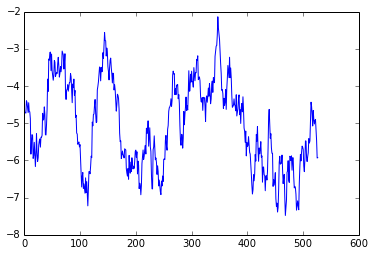

In [416]:
g.__class__ = KarpathyGame
g.plot_reward()

In [554]:
g = KarpathyGame(SETTINGS)

step_s = 1 / SETTINGS["fps"]
resolution = SETTINGS["resolution"]
speed_adjustment = 1.0

last_render_ts = time.time()

avg_render_time = step_s
while True:
    clear_output(wait=True)
    # rendering start
    start = time.time()
    display(g.to_html([
        "FPS    = %.1f" % (min(SETTINGS["fps"], 1 / avg_render_time),),
        "reward = %.3f" % (g.collect_reward(),),
        "DTW    = %.1f" % (g.distance_to_walls(),)
    ]))
    time_to_be_rendered = time.time() - last_render_ts
    last_render_ts = time.time()
    for _ in range(int(speed_adjustment * time_to_be_rendered / resolution)):
        g.step(resolution)
    render_time = time.time() - start
    # rendering end
    avg_render_time = 0.99 * avg_render_time + 0.01 * render_time
    if (step_s - render_time) > 0:
        time.sleep(step_s - render_time)

KeyboardInterrupt: 

TypeError: 'list' object cannot be interpreted as an integer

In [180]:
avg_render_time

1.2576193288630786

In [259]:
?np.linspace

In [507]:
def get(n, total, p_initial, p_final):
    if n >= total:
        return p_final
    else:
        return p_initial - (n * (p_initial - p_final)) / (total)

In [511]:
get(0, 100, 2.0, 0.05)

2.0